# Chinese characters generator 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_2hier64x64_27_01_18_11_01_02.txt"

X_vec = []
Y_img = []

img_size = 64
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([(float(n) - 127) / 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 50000 == 0):
        print("{} words processed".format(wcount))
    if wcount > 200000:
        break
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

50000 words processed
100000 words processed
126007 words processed


In [4]:
Y_img.shape, np.min(Y_img), np.max(Y_img)

((126007, 64, 64, 1), -1.0, 1.0078740157480315)

## Visualisation

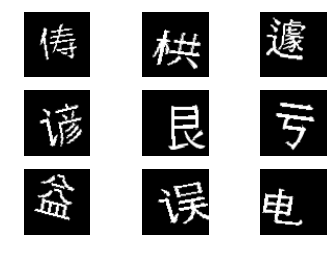

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

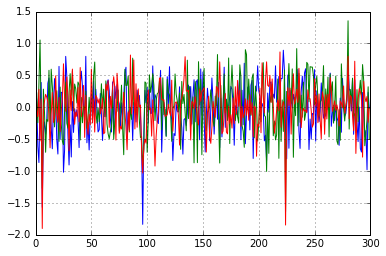

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [8]:
gen_dropout = 0.5
gen_input_dim = 4
gen_depth = 512
gen_noise_dim = 300
# gen_alpha = 0.2
gen_beta = 0.9

In [9]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 32), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 32), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              2465792   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
__________

## Discriminator

In [10]:
disc_depth = 64
disc_dropout = 0.5
disc_alpha = 0.2
disc_beta = 0.9

In [11]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(img_size, img_size, 1), 
                   padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 128)       0         
__________

## Discriminator model

In [12]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=SGD(lr=0.0002),
#                   optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [13]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=SGD(lr=0.0001),
#                  optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [14]:
disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

In [15]:
batch_size = 128
train_iters = 500
stop_loss = 7.0

log_i = 0

start_time = time.time()

for i in range(train_iters):
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    disc_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(disc_loss[0])
    disc_losses["acc"].append(disc_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Break if too big losses
    if disc_loss[0] > stop_loss or adv_loss[0] > stop_loss:
        print("Too big losses. Disc {:.3f} | Adv {:.3f}".format(dics_loss[0], adv_loss[0]))
        break
        
    if disc_loss[1] == 1.0:
        print("Disc doesn't learns.")
        break
    
    # Print results
    if i % 100 == 0:
        curr_time = time.time()
        if i > 0:
            time_est = (curr_time - start_time) * (train_iters - i) / i
        else:
            time_est = (curr_time - start_time) * train_iters
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}|".format(disc_loss[0], 
                                                                                          disc_loss[1], 
                                                                                          adv_loss[0], 
                                                                                          adv_loss[1]) +\
              "Time est {}".format(time_est_str))

   0th batch of  500|Disc loss 0.856 |Disc acc 0.410 |Adv loss 0.563 |Adv acc 0.703|Time est 0:59:32
 100th batch of  500|Disc loss 0.314 |Disc acc 0.871 |Adv loss 0.251 |Adv acc 0.914|Time est 0:03:47
 200th batch of  500|Disc loss 0.161 |Disc acc 0.961 |Adv loss 0.165 |Adv acc 0.953|Time est 0:02:42
Disc doesn't learns.


## Losses

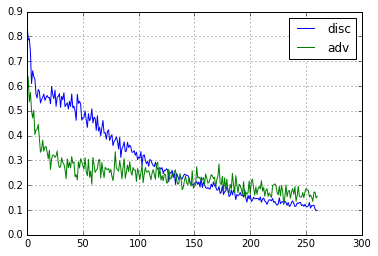

In [16]:
plt.plot(disc_losses["loss"], label="disc")
plt.plot(adv_losses["loss"], label="adv")
plt.grid()
plt.legend()
plt.show()

## Accuracies

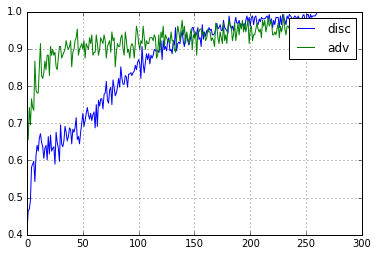

In [17]:
plt.plot(disc_losses["acc"], label="disc")
plt.plot(adv_losses["acc"], label="adv")
plt.grid()
plt.legend()
plt.show()

## An attempt to generate images

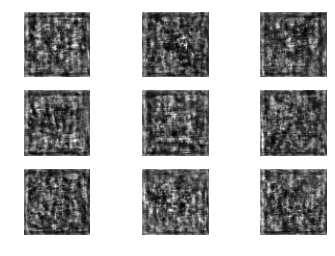

In [18]:
noise = np.random.uniform(-1.0, 1.0, size=[9, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()